In [ ]:
from rank_bm25 import BM25Plus

corpus = [
    "Hello there good man!",
    "It is quite windy in London",
    "How is the weather today?"
]

tokenized_corpus = [doc.split(" ") for doc in corpus]

bm25 = BM25Plus(tokenized_corpus)
# <rank_bm25.BM25Okapi at 0x1047881d0>
query = "windy London"
tokenized_query = query.split(" ")

doc_scores = bm25.get_scores(tokenized_query)


: 

In [5]:
print(tokenized_corpus)

[['Hello', 'there', 'good', 'man!'], ['It', 'is', 'quite', 'windy', 'in', 'London'], ['How', 'is', 'the', 'weather', 'today?']]


In [27]:
print(doc_scores)

[109.56224024  60.99944622  62.66540122 ...  62.56114853  63.74518247
  59.58511626]


In [2]:
import pandas as pd

df = pd.read_csv('qqpTrain.csv')

# Convert the dataframe to a dictionary
data = df.to_dict(orient='records')


In [3]:
data = data[:3500]
newData = []
bm25Query = []
bm25Answer = []
for idx1,d1 in enumerate(data):
    bm25Query.append(d1["question1"])
    bm25Answer.append(d1["question2"])
    for idx2,d2 in enumerate(data):
        isDuplicate = 0
        if idx1 == idx2 and d1["is_duplicate"] == 1:
            isDuplicate = 1
        newData.append({"question1":d1['question1'],"question2":d2['question2'],"is_duplicate":isDuplicate})
#data = newData


In [4]:
tokenized_answer = [doc.split(" ") for doc in bm25Answer]
tokenized_question = [doc.split(" ") for doc in bm25Query]
bm25 = BM25Plus(tokenized_answer)
bm25result = []
for idx,q in enumerate(tokenized_question):
    doc_scores = bm25.get_scores(q)
    
    result = [(ds,0) for ds in doc_scores]
    if data[idx]['is_duplicate'] == 1:
        result[idx] = (result[idx][0],1)
    bm25result+=(result)
    

In [5]:
print(len(bm25result))

12250000


In [6]:
import pickle

# Define the file path
file_path = "qqp3500bm25P.pkl"

# Serialize and save the list to a binary file using pickle
with open(file_path, "wb") as file:
    pickle.dump(bm25result, file)

In [30]:
def measure(bm25Result,threshold):
    counter = 0
    negCounter = 0
    totalDuplicate = 0
    totalScore = 0
    #threshold = -2 #0.1   -2
    for idx,r in enumerate(bm25Result):  #positive result have negative score
        if r[0] <= threshold and r[1] == 1:
            counter += 1
        if r[0] > threshold and r[1] == 0:
            negCounter += 1
        if r[1] == 1:
            totalDuplicate += 1
        totalScore += r[0]
    #print(totalDuplicate)
    return counter/totalDuplicate, negCounter/(len(bm25Result)-totalDuplicate)
    #print((counter + negCounter) / len(bm25Result))
    #print(counter)
    #print(negCounter)
    #print(totalDuplicate/len(bm25Result))
    #print(totalScore/ len(bm25Result))

In [31]:
import numpy as np
xAxis = np.linspace(-4,0.1,51).tolist()
truePos = []
trueNeg = []
for threshold in xAxis:
    tp,tn = measure(bm25Result,threshold)
    truePos.append(tp)
    trueNeg.append(tn)


In [28]:
for d in bm25Result:
    if d[1] == '1':
        print(d)
    break

0.6400274138861071


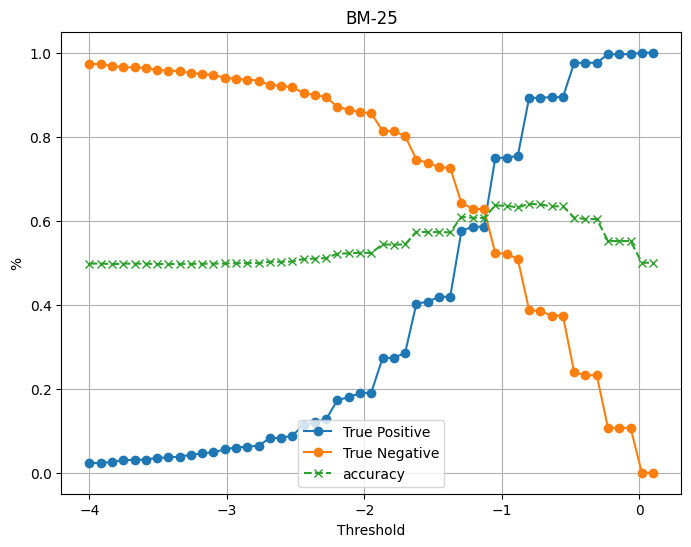

In [12]:
import matplotlib.pyplot as plt

# Sample data
x_values = xAxis  # X-axis values
y1_values = truePos  # First set of Y-axis values
y2_values = trueNeg  # Second set of Y-axis values
accuracy = [(y1+y2)/2 for y1,y2 in zip(y1_values,y2_values)]
print(max(accuracy))
# Create the line graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(x_values, y1_values, label='True Positive', marker='o', linestyle='-')
plt.plot(x_values, y2_values, label='True Negative', marker='o', linestyle='-')
plt.plot(x_values, accuracy, label='accuracy', marker='x', linestyle='--')

# Add labels and a legend
plt.xlabel('Threshold')
plt.ylabel('%')
plt.title('BM-25')
plt.legend()

# Show the graph (or save it to a file with plt.savefig)
plt.grid(True)  # Optional: Show grid lines
plt.show()


In [12]:
negativeScore = []
positiveScore = []
bestAcc = 0
bestAccIdx = 0
for idx,acc in enumerate(accuracy):
    if acc > bestAcc:
        bestAcc = acc
        bestAccIdx = idx
bestThreshold = xAxis[bestAccIdx]

for r in bm25Result:
    if r[1] == 1:
        positiveScore.append(r[0])
    else:
        negativeScore.append(r[0])

positiveScore.sort()
negativeScore.sort()


In [13]:
def cutOff(MOE, bestThreshold):
    posCutOff = 0
    posInAccurateCount = 0
    negCutOff = 0
    negInAccurateCount = 0
    for idx, s in enumerate((positiveScore)):
        if s > bestThreshold:
            posInAccurateCount += 1
        if posInAccurateCount / max(idx,100) > MOE:
            posCutOff = idx
            break
    if posCutOff == 0:
        posCutOff = len(positiveScore)

    for idx, s in enumerate(reversed(negativeScore)):
        if s <= bestThreshold:
            negInAccurateCount += 1
        if negInAccurateCount / max(idx,100) > MOE:
            negCutOff = idx
            break
    if negCutOff == 0:
        negCutOff = len(positiveScore)

    return (negCutOff+posCutOff)/len(bm25Result)

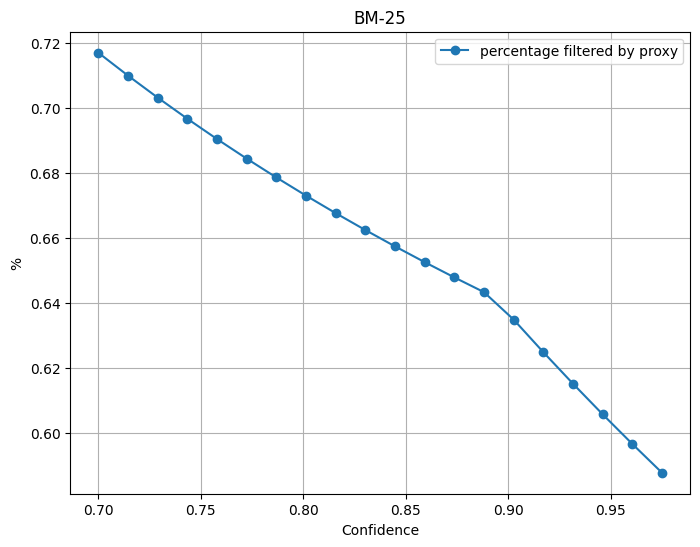

In [15]:
xAxis = np.linspace(0.975,0.7,20).tolist()
filterPercentage = []
for confidence in xAxis:
    filterPercentage.append(cutOff(MOE=1-confidence,bestThreshold=bestThreshold))
# Sample data
x_values = xAxis  # X-axis values
y_values = filterPercentage  # First set of Y-axis values

# Create the line graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(x_values, y_values, label='percentage filtered by proxy', marker='o', linestyle='-')


# Add labels and a legend
plt.xlabel('Confidence')
plt.ylabel('%')
plt.title('BM-25')
plt.legend()

# Show the graph (or save it to a file with plt.savefig)
plt.grid(True)  # Optional: Show grid lines
plt.show()


In [6]:
import os
import csv
dataset_path = 'quora-dataset/'
first5000 = []
with open(os.path.join(dataset_path, 'classification', 'test_pairs.tsv'), 'r', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if len(first5000) >= 5000:
            break
        first5000.append((row['question1'], row['question2'], row['is_duplicate']))

pairs = []
for Iidx in range(len(first5000)):
    for Jidx in range(len(first5000)):
        label = 0
        if Iidx == Jidx and first5000[2] == 1:
            label = 1
        pairs.append((first5000[Iidx][0], first5000[Jidx][1], label))


In [7]:
print(len(pairs))

25000000
